In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt
from gpytorch import ExactMarginalLogLikelihood
from torch.utils.data import DataLoader, TensorDataset
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.constraints import GreaterThan
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.priors import GammaPrior
from botorch.models import SingleTaskVariationalGP

# Define synthetic data
n_train = 150
n_test = 100
x_train = torch.linspace(0, 1, n_train, dtype=torch.double).unsqueeze(1)
x_test = torch.linspace(0, 1, n_test, dtype=torch.double).unsqueeze(1)
y_train = torch.where(x_train < 0.5, torch.tensor(1.0, dtype=torch.double), torch.tensor(-1.0)) + 0.1 * torch.randn(n_train, 1)
y_test = torch.where(x_test < 0.5, torch.tensor(1.0, dtype=torch.double), torch.tensor(-1.0)) + 0.1 * torch.randn(n_test, 1)
x_train = x_train.cuda()
y_train = y_train.cuda()
x_test = x_test.cuda()
y_test = y_test.cuda()

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

print(x_train.shape)
print(y_train.shape)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

torch.Size([150, 1])
torch.Size([150, 1])


In [2]:
from gp.deepgp import BotorchDeepGP
from gpytorch.mlls import DeepApproximateMLL
from gp.mixeddeepgp import BotorchDeepGPMixed

# Train the deep GP model
deep_gp = BotorchDeepGP(train_x_shape=x_train.shape, num_hidden_dims=1, num_inducing_points=128)
deep_gp = deep_gp.cuda()

deep_gp.train()
deep_gp.likelihood.train()

optimizer = torch.optim.Adam(deep_gp.parameters(), lr=0.01)
mll = gpytorch.mlls.VariationalELBO(deep_gp.likelihood, deep_gp, y_train.numel())

y_train_ = y_train.squeeze(1)

training_iterations = 200
for i in range(training_iterations):
    optimizer.zero_grad()
    output = deep_gp(x_train)
    loss = -mll(output, y_train_).mean()
    loss.backward()
    optimizer.step()

In [3]:
# Train the variational GP model
var_gp = SingleTaskVariationalGP(train_X=x_train, train_Y=y_train, inducing_points=128)
var_gp = var_gp.cuda()
var_gp.train()
var_gp.likelihood.train()

optimizer = torch.optim.Adam(var_gp.parameters(), lr=0.01)
mll = DeepApproximateMLL(gpytorch.mlls.VariationalELBO(var_gp.likelihood, var_gp.model, y_train.numel()))

y_train_ = y_train.squeeze(1)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = var_gp(x_train)
    loss = -mll(output, y_train_)
    loss.backward()
    optimizer.step()

/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0101], device='cuda:0', dtype=torch.float64), std = tensor([1.0108], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [4]:
from botorch.models import SingleTaskGP

gp = SingleTaskGP(train_X=x_train, train_Y=y_train)
gp = gp.cuda()

optimizer = torch.optim.Adam(var_gp.parameters(), lr=0.01)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = gp(x_train)
    loss = -mll(output, y_train_)
    loss.backward()
    optimizer.step()


In [5]:
# Warning: does depend on global variables
def predict_and_plot_deep_gp(model, train_loader, test_loader):
    # Predict on train data
    train_means = torch.tensor([0.])
    train_variances = torch.tensor([0.])
    with torch.no_grad():
        for x_batch, y_batch in train_loader:
            preds = model.posterior(x_batch)
            for pred in preds.mean:
                train_means = torch.cat([train_means, pred.cpu()])
            for vars in preds.variance:
                train_variances = torch.cat([train_variances, vars.cpu()])
    train_means = train_means[1:]
    train_variances = train_variances[1:]

    # Predict on test data
    test_means = torch.tensor([0.])
    test_variances = torch.tensor([0.])
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            preds = model.posterior(x_batch)
            for pred in preds.mean:
                test_means = torch.cat([test_means, pred.cpu()])
            for vars in preds.variance:
                test_variances = torch.cat([test_variances, vars.cpu()])
    test_means = test_means[1:]
    test_variances = test_variances[1:]

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(x_train.cpu().numpy(), y_train.cpu().numpy(), 'k*', label='Training Data')
    
    plt.plot(x_train.cpu().numpy(), train_means.cpu().numpy(), 'b', label='Train predictions')
    # plt.plot(x_test.cpu().numpy(), test_means.cpu().numpy(), 'r', label='Test predictions')

    # Plot training variance as a shaded area
    plt.fill_between(x_train.squeeze().cpu().numpy(),
                     train_means.cpu().numpy() - 2 * train_variances.cpu().numpy() ** 0.5,
                     train_means.cpu().numpy() + 2 * train_variances.cpu().numpy() ** 0.5,
                     color='b', alpha=0.2, label='Train predictive variance')

    """
    # Plot test variance as a shaded area
    plt.fill_between(x_test.cpu().squeeze().numpy(),
                     test_means.cpu().numpy() - 2 * test_variances.cpu().numpy() ** 0.5,
                     test_means.cpu().numpy() + 2 * test_variances.cpu().numpy() ** 0.5,
                     color='r', alpha=0.2, label='Test predictive variance')
    """

    plt.legend()
    plt.show()

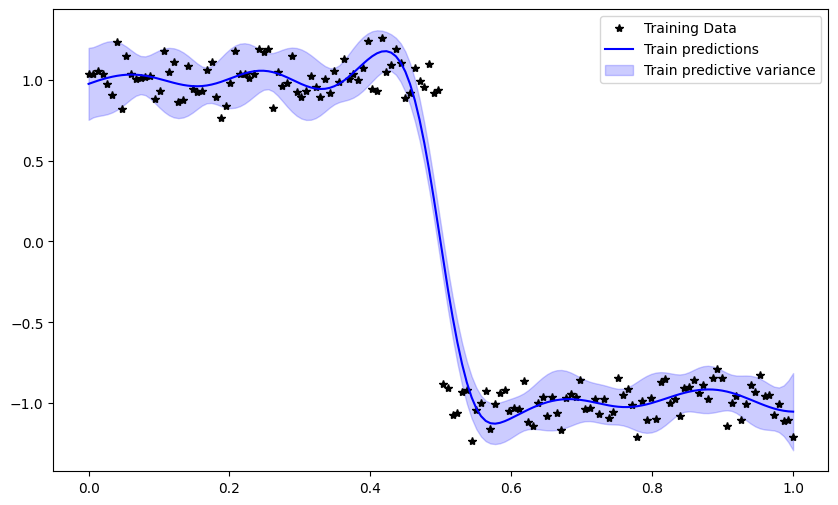

In [6]:
# Predict and plot for Variational GP
predict_and_plot_deep_gp(var_gp, train_loader, test_loader)

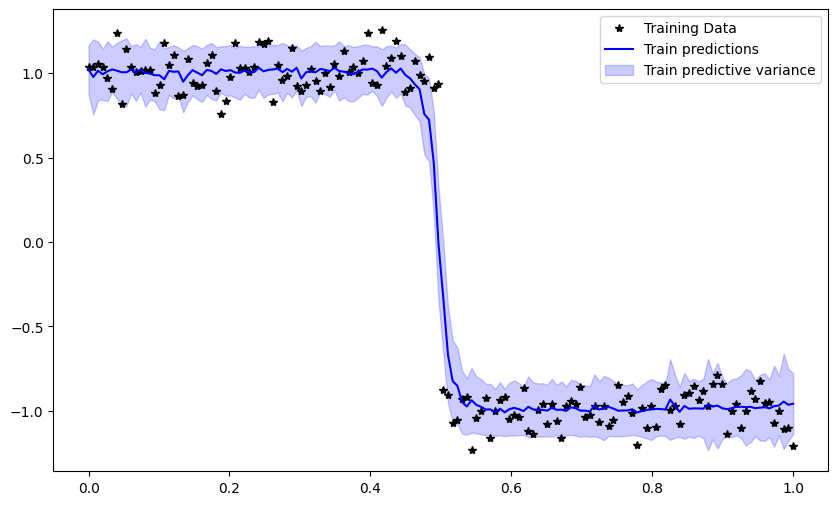

In [7]:
predict_and_plot_deep_gp(deep_gp, train_loader, test_loader)

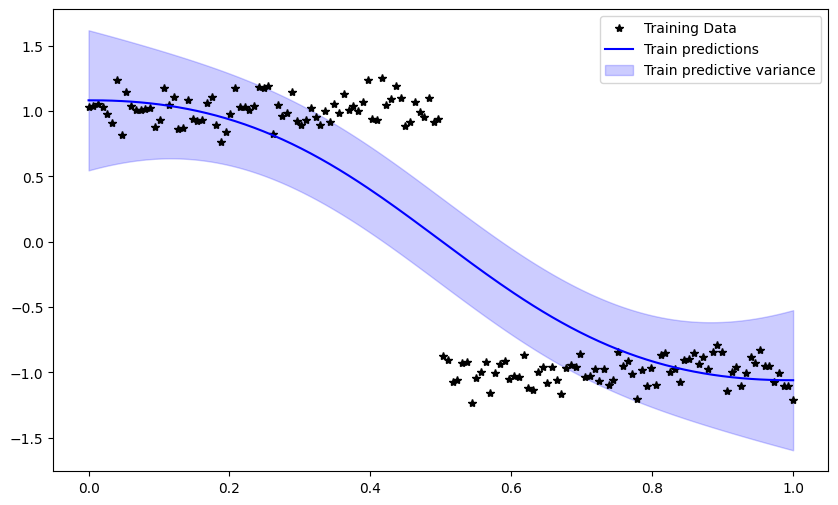

In [8]:
predict_and_plot_deep_gp(gp, train_loader, test_loader)